In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv("salaries.csv")
print(df.shape)
df.head()

(397, 6)


,rank,discipline,yrs.since.phd,yrs.service,sex,salary
0,Prof,B,19,18,Male,139750
1,Prof,B,20,16,Male,173200
2,AsstProf,B,4,3,Male,79750
3,Prof,B,45,39,Male,115000
4,Prof,B,40,41,Male,141500


In [4]:
#Summary statistics
df.describe()

,yrs.since.phd,yrs.service,salary
count,397.000000,397.000000,397.000000
mean,22.314861,17.614610,113706.458438
std,12.887003,13.006024,30289.038695
min,1.000000,0.000000,57800.000000
25%,12.000000,7.000000,91000.000000
50%,21.000000,16.000000,107300.000000
75%,32.000000,27.000000,134185.000000
max,56.000000,60.000000,231545.000000


In [42]:
df.isnull().sum()

,0
rank,0
discipline,0
yrs.since.phd,0
yrs.service,0
sex,0
salary,0


In [29]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
print(categorical_columns)


Index(['rank', 'discipline', 'sex'], dtype='object')


In [46]:
# Convert categorical variables into dummy variables
df_dummies = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


KeyError: "None of [Index(['rank_AsstProf', 'discipline_B', 'rank_Prof'], dtype='object')] are in the [columns]"

In [47]:
# Display the DataFrame with dummy variables
print(df_dummies.head())

   yrs.since.phd  yrs.service  salary  rank_AsstProf  rank_Prof  discipline_B  \
0             19           18  139750              0          1             1   
1             20           16  173200              0          1             1   
2              4            3   79750              1          0             1   
3             45           39  115000              0          1             1   
4             40           41  141500              0          1             1   

   sex_Male  
0         1  
1         1  
2         1  
3         1  
4         1  


In [48]:
# compute the correlation matrix
correlation_matrix = df_dummies.corr()


<Axes: >

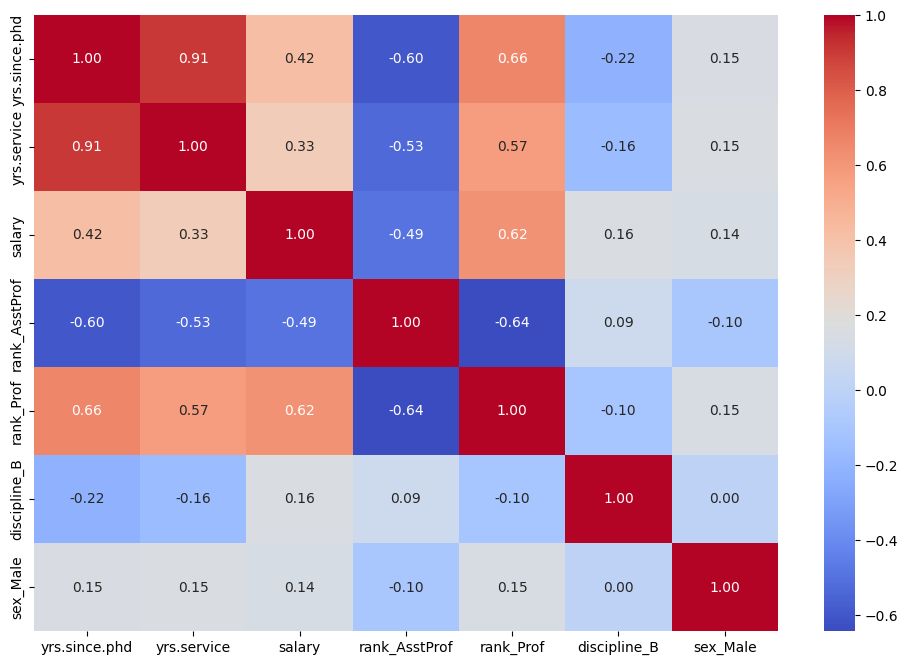

In [49]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

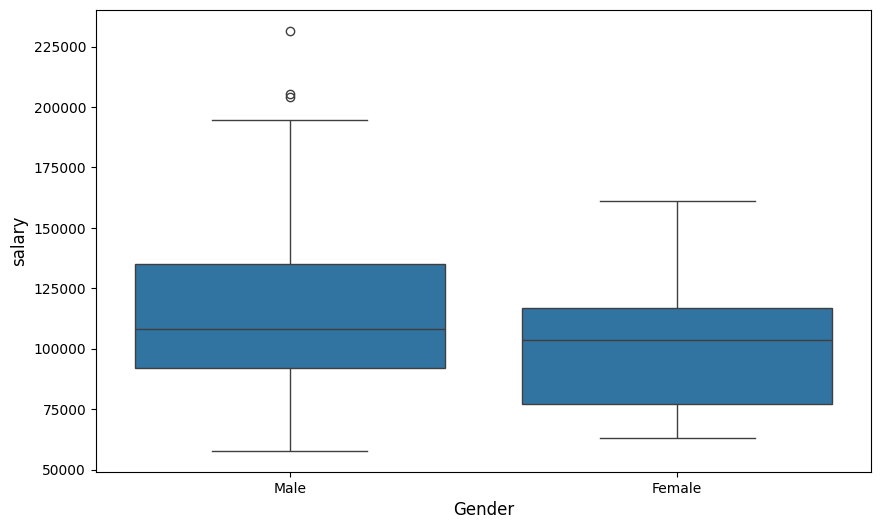

In [52]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_dummies['sex_Male'].replace({1: 'Male', 0: 'Female'}),
            y='salary',
            data=df_dummies)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('salary', fontsize=12)
plt.show()

**2 Multilinear Regression Model**

In [56]:
# Exclude target variable
X = df_dummies.drop('salary', axis=1)
y = df_dummies['salary']

#Initialize Scaler
scaler = StandardScaler()


#Fit and transofrm features
X_standarized = scaler.fit_transform(X)


In [57]:
# Convert to a dataframe
X_standarized = pd.DataFrame(X_standarized, columns=X.columns)

X_standarized.head()

,yrs.since.phd,yrs.service,rank_AsstProf,rank_Prof,discipline_B,sex_Male
0,-0.257550,0.029669,-0.450589,0.701770,0.915403,0.330058
1,-0.179854,-0.124300,-0.450589,0.701770,0.915403,0.330058
2,-1.422982,-1.125098,2.219318,-1.424968,0.915403,0.330058
3,1.762533,1.646343,-0.450589,0.701770,0.915403,0.330058
4,1.374055,1.800312,-0.450589,0.701770,0.915403,0.330058


In [58]:
#prepare x and y
y = df_dummies['salary']
X_standarized = sm.add_constant(X)

In [60]:

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_standarized, y,
                                                    test_size = 0.2,
                                                    random_state = 1502)

In [61]:
model = sm.OLS(y_train1, X_train1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 salary   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     46.96
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           8.47e-41
Time:                        18:12:29   Log-Likelihood:                -3613.5
No. Observations:                 317   AIC:                             7241.
Df Residuals:                     310   BIC:                             7267.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          7.886e+04   5479.688     14.392

In [63]:
#predictions for multilinear regression model
predictions_multilinear = model.predict(X_test1)
predictions_multilinear

,0
364,117218.181686
30,137359.607205
378,117404.155949
188,99065.754032
155,133731.758840
...,...
343,133359.810314
366,119381.716782
79,87704.957414
135,118522.494985


In [64]:
results_multilinear = pd.DataFrame({
    'Actual': y_test1.values.astype(int),
    'Predicted': predictions_multilinear.astype(int)
})
results_multilinear

,Actual,Predicted
364,205500,117218
30,132261,137359
378,150680,117404
188,106300,99065
155,118971,133731
...,...,...
343,162150,133359
366,115435,119381
79,84240,87704
135,136000,118522


In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
print("MAE:", round(mean_absolute_error(y_test1, predictions_multilinear), 0))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test1, predictions_multilinear)), 0))

MAE: 18027.0
RMSE: 25448.0


**3 Tree Regression**

In [66]:
from sklearn.tree import DecisionTreeRegressor

In [67]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 1502)

In [68]:
#Initialize
tree_model = DecisionTreeRegressor(random_state=42)

#Train
tree_model.fit(X_train2, y_train2)

DecisionTreeRegressor(random_state=42)

In [69]:
feature_importances = tree_model.feature_importances_

In [70]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(importance_df)

         Feature  Importance
3      rank_Prof    0.422131
0  yrs.since.phd    0.242765
1    yrs.service    0.224974
4   discipline_B    0.074614
5       sex_Male    0.018906
2  rank_AsstProf    0.016611


In [71]:
predictions_tree = tree_model.predict(X_test2)

In [72]:
results_multilinear = pd.DataFrame({
    'Actual': y_test2.values.astype(int),
    'Predicted': predictions_tree.astype(int)
})
results_multilinear

,Actual,Predicted
0,205500,143940
1,132261,165000
2,150680,135200
3,106300,105350
4,118971,170000
...,...,...
75,162150,162221
76,115435,114330
77,84240,88825
78,136000,126300


In [73]:
print("MAE:", round(mean_absolute_error(y_test2, predictions_tree), 0))
print("RMSE:", round(np.sqrt(mean_squared_error(y_test2, predictions_tree)), 0))

MAE: 20950.0
RMSE: 29733.0


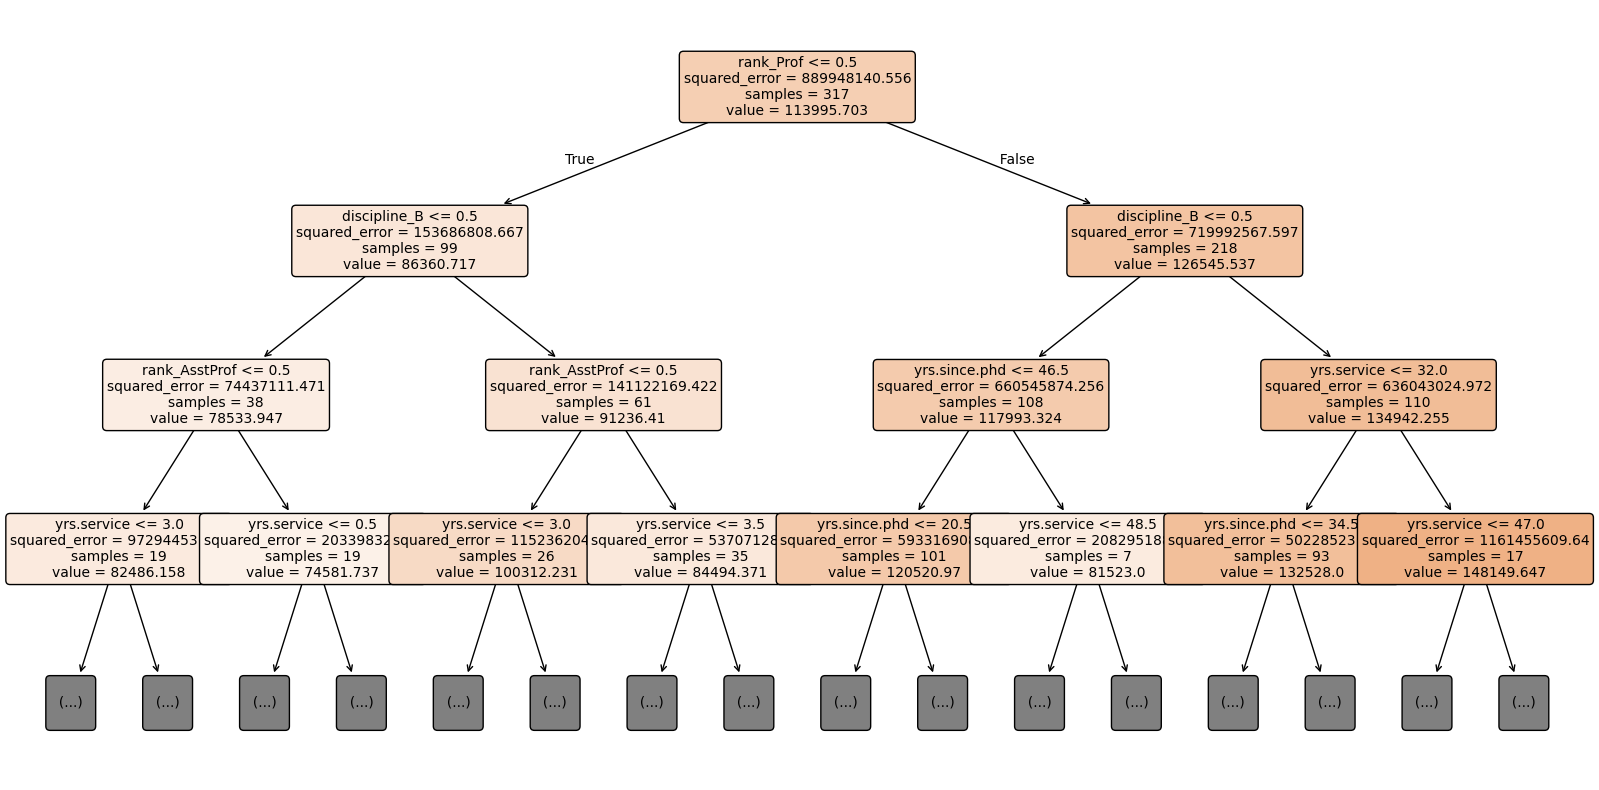

In [75]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(tree_model, feature_names=X.columns, max_depth=3, filled=True, rounded=True,fontsize=10)
plt.show()